## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from qiskit import QuantumCircuit
from qiskit.primitives import Estimator
from qiskit.circuit.library import ZFeatureMap, EfficientSU2
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp

## Defining Parameters

This section establishes the necessary constants required to replicate and analyze the study:


N_QUBITS = 4: This value is a direct result of the PCA pre-processing, which reduced the input data to 4 dimensions for quantum encoding.

TARGET_ACCURACY = 0.80: This sets the Efficiency goal. Our primary metric is the minimum number of labels required for the model to reach this threshold.

RANDOM_SEED = 42: Used to ensure reproducibility. By fixing the initial state across all runs, we isolate and accurately measure Robustness using the Standard Deviation ($\sigma$) of the results.

TOTAL_QUERY_BATCH_SIZE = 10: This defines the Active Learning Strategies. This value allows us to systematically compare all 11 possible Passive : Active (P:A) sampling proportions, which is the core focus of our research.

In [ ]:
N_QUBITS = 4
N_LAYERS = 3
TARGET_ACCURACY = 0.80
RANDOM_SEED = 44

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


DIGITS_TO_CLASSIFY = [0, 1]
N_INITIAL_SAMPLES = 20
TOTAL_QUERY_BATCH_SIZE = 10 
ACTIVE_BATCH_SIZE = 200     
BATCH_SIZE_TRAIN = 10


LEARNING_RATE = 0.01
N_INITIAL_EPOCHS = 50       
N_FINETUNE_EPOCHS = 2       

## Now we will start the pre-processing
Here we will load MNIST dataset, Apply PCA and then divide by the digits to classify:

$$ [0,1]$$

In [10]:
def load_and_preprocess_data():
    
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    y = y.astype(int)

    mask = np.isin(y, DIGITS_TO_CLASSIFY)
    X_filtered = X[mask]
    y_filtered = y[mask]
    y_mapped = np.where(y_filtered == DIGITS_TO_CLASSIFY[0], 0, 1)

    X_scaled = X_filtered / 255.0 
    pca = PCA(n_components=N_QUBITS)
    X_pca = pca.fit_transform(X_scaled)

    X_pool, X_test, y_pool, y_test = train_test_split(
        X_pca, y_mapped, 
        test_size=0.3, random_state=RANDOM_SEED, stratify=y_mapped
    )
    
    return X_pool, y_pool, X_test, y_test


## Hybrid Model (QNN)

Quantum Circuit Creation (QNN): The code constructed the quantum circuit by combining the ZFeatureMap (to encode the 4 PCA features) with the EfficientSU2 (the ansatz containing the trainable parameters).

Hybrid Integration: The TorchConnector was utilized to wrap the QNN (now an EstimatorQNN) and integrate it as a layer (nn.Module) into the classical PyTorch framework.

In [11]:
class HybridQNN(nn.Module):
    
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        
        feature_map = ZFeatureMap(n_qubits)
        ansatz = EfficientSU2(n_qubits, reps=n_layers)
        
        qc = QuantumCircuit(n_qubits)
        qc.compose(feature_map, inplace=True)
        qc.compose(ansatz, inplace=True)
        
        pauli_string = "I" * (n_qubits - 1) + "Z" 
        observable = SparsePauliOp(pauli_string)
        
        estimator = Estimator()

        qnn = EstimatorQNN(
            circuit=qc,
            observables=observable,
            input_params=feature_map.parameters,
            weight_params=ansatz.parameters,
            estimator=estimator,
        )

        self.q_layer = TorchConnector(
            qnn,
            
            initial_weights=np.random.rand(ansatz.num_parameters),
        )
        
        self.c_layer = nn.Linear(1, 2) 

    def forward(self, x):
        x = self.q_layer(x)
        x = self.c_layer(x)
        return x


## RUN SIMULATION FUNCTION

The run_simulation function executes the complete Active Learning (AL) loop for one specific sampling strategy (Passive : Active mix).

It repeatedly queries new labels until the model reaches the TARGET_ACCURACY (80%).

It applies Uncertainty Sampling to select the active samples (those with maximum uncertainty) and combines them with passively selected random samples.

It measures the number of labels required for the model to achieve the target, providing the core data for comparing the Efficiency of each strategy.

In [12]:
def run_simulation(config_name, n_passive_per_batch, n_active_per_batch, X_pool, y_pool, X_test_tensor, y_test_tensor, initial_indices, initial_model_state):
   
    local_X_pool = np.copy(X_pool)
    local_y_pool = np.copy(y_pool)
    
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TRAIN)

    
    labeled_X_pca = [torch.tensor(local_X_pool[i], dtype=torch.float32) for i in initial_indices]
    labeled_y = [torch.tensor(local_y_pool[i], dtype=torch.long) for i in initial_indices]
    
    unlabeled_indices = np.array(list(set(range(len(local_y_pool))) - set(initial_indices)))
    
    
    model = HybridQNN(N_QUBITS, N_LAYERS)
    model.load_state_dict(initial_model_state) 
    
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    
    current_accuracy = 0.0
    history = [] 
    
    while current_accuracy < TARGET_ACCURACY and len(unlabeled_indices) > 0:
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        current_accuracy = correct / total
        n_labeled = len(labeled_y)
        history.append((n_labeled, current_accuracy))
        print(f"[{config_name}] Labels: {n_labeled:4d} | Precision: {current_accuracy:.4f}")

        if current_accuracy >= TARGET_ACCURACY:
            break
            
        
        new_labels_pca = []
        new_labels_y = []
        indices_to_remove = []
        
        current_unlabeled_indices = np.copy(unlabeled_indices) 

        
        n_to_query_passive = min(n_passive_per_batch, len(current_unlabeled_indices))
        if n_to_query_passive > 0:
            
            passive_indices = np.random.choice(current_unlabeled_indices, n_to_query_passive, replace=False)
            
            for idx in passive_indices:
                new_labels_pca.append(torch.tensor(local_X_pool[idx], dtype=torch.float32))
                new_labels_y.append(torch.tensor(local_y_pool[idx], dtype=torch.long))
                indices_to_remove.append(idx)
            
            mask_to_remove_passive = np.isin(current_unlabeled_indices, passive_indices)
            current_unlabeled_indices = current_unlabeled_indices[~mask_to_remove_passive]

        
        n_to_query_active = min(n_active_per_batch, len(current_unlabeled_indices))
        if n_to_query_active > 0:
            
            n_to_check = min(ACTIVE_BATCH_SIZE, len(current_unlabeled_indices))
            if n_to_check == 0:
                break
                
            batch_indices_relative = np.random.choice(range(len(current_unlabeled_indices)), n_to_check, replace=False)
            batch_indices_absolute = current_unlabeled_indices[batch_indices_relative]
            
            X_U_batch_pca = torch.tensor(local_X_pool[batch_indices_absolute], dtype=torch.float32)
            
            with torch.no_grad():
                outputs = model(X_U_batch_pca)
                probs = torch.softmax(outputs, dim=1)
            
            uncertainty = torch.abs(probs[:, 0] - probs[:, 1])
            most_uncertain_indices_relative = torch.argsort(uncertainty)[:n_to_query_active]
            
            active_indices_raw = batch_indices_absolute[most_uncertain_indices_relative]
            active_indices = np.atleast_1d(active_indices_raw) # Correção do bug anterior

            for idx in active_indices:
                new_labels_pca.append(torch.tensor(local_X_pool[idx], dtype=torch.float32))
                new_labels_y.append(torch.tensor(local_y_pool[idx], dtype=torch.long))
                indices_to_remove.append(idx)

       
        labeled_X_pca.extend(new_labels_pca)
        labeled_y.extend(new_labels_y)
        
        
        mask_to_remove_all = np.isin(unlabeled_indices, indices_to_remove)
        unlabeled_indices = unlabeled_indices[~mask_to_remove_all]
        
        
        train_dataset = TensorDataset(torch.stack(labeled_X_pca), torch.stack(labeled_y))
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
        
        model.train()
        for epoch in range(N_FINETUNE_EPOCHS):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
            
    return history

# Main Script

The Main Script sets up the common conditions, executes all 11 individual simulation runs, and visualizes the aggregated results.

It loads the data (applying PCA reduction), and trains a common HybridQNN baseline model using the initial samples, to ensure all tests start identically.

It loops through and executes all 11 Active/Passive (P:A) sampling proportions (from $10P+0A$ to $0P+10A$), calling the run_simulation function for each.

It aggregates the results from all strategies (total labels needed vs. accuracy) and generates the final comparative plot used to analyze Efficiency.

/var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_91691/1025312770.py:16: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/var/folders/rs/wmb9tlw54_57w8bqd4qxp_zh0000gn/T/ipykernel_91691/1025312770.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


[(10P + 0A)] Labels:   20 | Precision: 0.6994
[(10P + 0A)] Labels:   30 | Precision: 0.7113
[(10P + 0A)] Labels:   40 | Precision: 0.7215
[(10P + 0A)] Labels:   50 | Precision: 0.7158
[(10P + 0A)] Labels:   60 | Precision: 0.7172
[(10P + 0A)] Labels:   70 | Precision: 0.7201
[(10P + 0A)] Labels:   80 | Precision: 0.7318
[(10P + 0A)] Labels:   90 | Precision: 0.7427
[(10P + 0A)] Labels:  100 | Precision: 0.7641
[(10P + 0A)] Labels:  110 | Precision: 0.7715
[(10P + 0A)] Labels:  120 | Precision: 0.7909
[(10P + 0A)] Labels:  130 | Precision: 0.7909
[(10P + 0A)] Labels:  140 | Precision: 0.7907
[(10P + 0A)] Labels:  150 | Precision: 0.7821
[(10P + 0A)] Labels:  160 | Precision: 0.7776
[(10P + 0A)] Labels:  170 | Precision: 0.7952
[(10P + 0A)] Labels:  180 | Precision: 0.7853
[(10P + 0A)] Labels:  190 | Precision: 0.7979
[(10P + 0A)] Labels:  200 | Precision: 0.7979
[(10P + 0A)] Labels:  210 | Precision: 0.7957
[(10P + 0A)] Labels:  220 | Precision: 0.8022
Simulation time (10P + 0A): 8.07 m

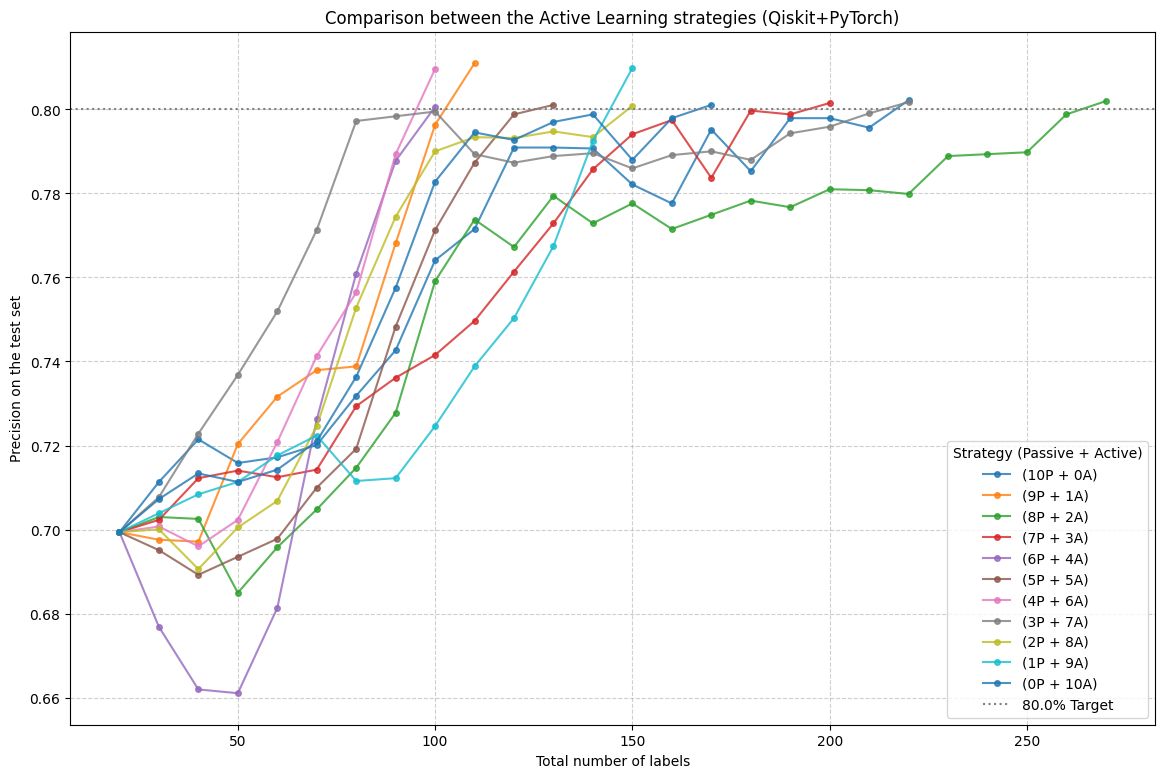

In [13]:
if __name__ == "__main__":
    
    
    X_pool, y_pool, X_test_np, y_test_np = load_and_preprocess_data()
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)


    initial_indices = np.random.choice(range(len(y_pool)), N_INITIAL_SAMPLES, replace=False)
    
    
    labeled_X_pca = [torch.tensor(X_pool[i], dtype=torch.float32) for i in initial_indices]
    labeled_y = [torch.tensor(y_pool[i], dtype=torch.long) for i in initial_indices]
    
    train_dataset = TensorDataset(torch.stack(labeled_X_pca), torch.stack(labeled_y))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
    
    
    initial_model = HybridQNN(N_QUBITS, N_LAYERS)
    optimizer = optim.Adam(initial_model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    
    initial_model.train()
    for epoch in range(N_INITIAL_EPOCHS):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = initial_model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
    
    
    initial_model_state = initial_model.state_dict()
    
    
    configurations = []
    for n_active in range(TOTAL_QUERY_BATCH_SIZE + 1): 
        n_passive = TOTAL_QUERY_BATCH_SIZE - n_active
        config_name = f"({n_passive}P + {n_active}A)"
        configurations.append((config_name, n_passive, n_active))
    
    results = {}

    start_time_total = time.time()

    for name, n_p, n_a in configurations:
        start_time_sim = time.time()
        
        history = run_simulation(
            name, n_p, n_a, 
            X_pool, y_pool, X_test_tensor, y_test_tensor,
            initial_indices, initial_model_state
        )
        results[name] = history
        print(f"Simulation time {name}: {(time.time() - start_time_sim)/60:.2f} minutes")

    print(f"Total time: {(time.time() - start_time_total)/60:.2f} minutes")

    
    plt.figure(figsize=(14, 9))
    
    for name, history in results.items():
        if history:
            x_data, y_data = zip(*history)
            plt.plot(x_data, y_data, 'o-', label=name, markersize=4, alpha=0.8)

    plt.axhline(y=TARGET_ACCURACY, color='gray', linestyle=':', label=f"{TARGET_ACCURACY * 100}% Target")
    plt.xlabel("Total number of labels")
    plt.ylabel("Precision on the test set")
    plt.title("Comparison between the Active Learning strategies (Qiskit+PyTorch)")
    plt.legend(title="Strategy (Passive + Active)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

## Evolution of Accuracy by Strategy (Learning Curves)

This cell uses data from a single simulation run  to plot the Learning Curves for all 11 Active Learning (AL) strategies. Its core function is to visually compare their Efficiency (accuracy vs. number of labeled samples) against the 80% target accuracy.

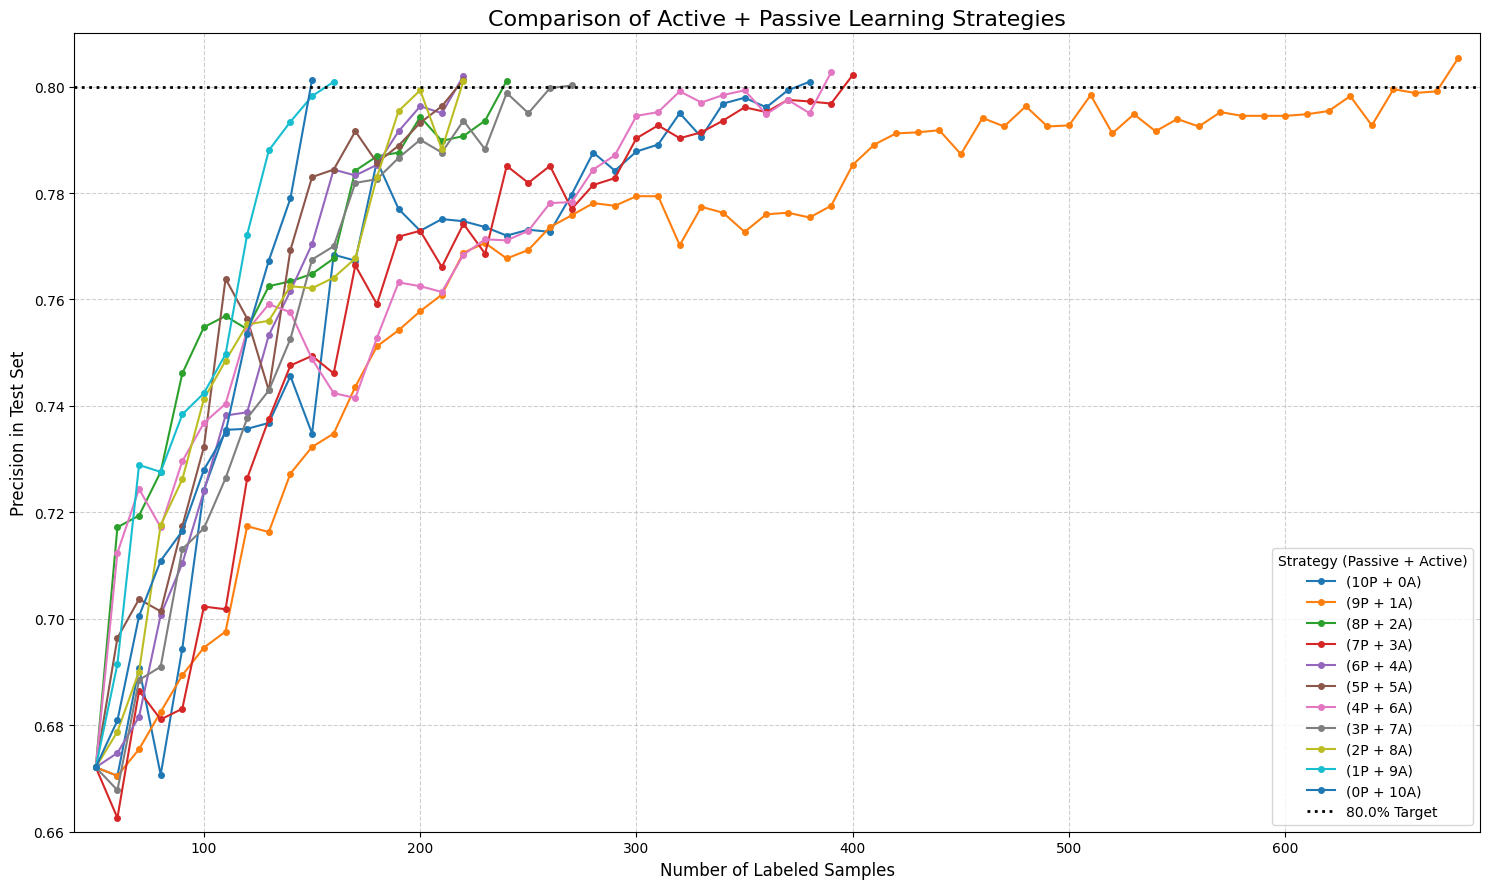

In [ ]:
data = {
    '(10P + 0A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380],
        'precision': [0.6721, 0.6705, 0.6908, 0.6707, 0.6944, 0.7242, 0.7355, 0.7357, 0.7368, 0.7456, 0.7348, 0.7684, 0.7673, 0.7860, 0.7770, 0.7729, 0.7751, 0.7747, 0.7736, 0.7720, 0.7731, 0.7727, 0.7797, 0.7876, 0.7842, 0.7878, 0.7891, 0.7950, 0.7905, 0.7968, 0.7979, 0.7961, 0.7993, 0.8009]
    },
    '(9P + 1A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680],
        'precision': [0.6721, 0.6705, 0.6755, 0.6825, 0.6894, 0.6946, 0.6976, 0.7174, 0.7163, 0.7273, 0.7323, 0.7348, 0.7436, 0.7512, 0.7542, 0.7578, 0.7609, 0.7688, 0.7706, 0.7677, 0.7693, 0.7736, 0.7758, 0.7781, 0.7776, 0.7794, 0.7794, 0.7702, 0.7774, 0.7763, 0.7727, 0.7760, 0.7763, 0.7754, 0.7776, 0.7853, 0.7891, 0.7912, 0.7914, 0.7918, 0.7873, 0.7941, 0.7925, 0.7963, 0.7925, 0.7927, 0.7984, 0.7912, 0.7948, 0.7916, 0.7939, 0.7925, 0.7952, 0.7945, 0.7945, 0.7945, 0.7948, 0.7954, 0.7982, 0.7927, 0.7995, 0.7988, 0.7991, 0.8054]
    },
    '(8P + 2A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240],
        'precision': [0.6721, 0.7172, 0.7194, 0.7276, 0.7461, 0.7548, 0.7569, 0.7544, 0.7625, 0.7634, 0.7648, 0.7677, 0.7842, 0.7869, 0.7876, 0.7943, 0.7898, 0.7907, 0.7936, 0.8011]
    },
    '(7P + 3A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400],
        'precision': [0.6721, 0.6626, 0.6865, 0.6811, 0.6831, 0.7023, 0.7018, 0.7264, 0.7375, 0.7476, 0.7494, 0.7461, 0.7664, 0.7591, 0.7718, 0.7729, 0.7661, 0.7742, 0.7686, 0.7851, 0.7819, 0.7851, 0.7770, 0.7815, 0.7828, 0.7903, 0.7927, 0.7903, 0.7914, 0.7936, 0.7961, 0.7952, 0.7975, 0.7972, 0.7968, 0.8022]
    },
    '(6P + 4A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6748, 0.6816, 0.7007, 0.7104, 0.7240, 0.7382, 0.7388, 0.7533, 0.7616, 0.7704, 0.7844, 0.7833, 0.7853, 0.7916, 0.7963, 0.7950, 0.8020]
    },
    '(5P + 5A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6964, 0.7037, 0.7014, 0.7174, 0.7323, 0.7639, 0.7564, 0.7429, 0.7693, 0.7830, 0.7844, 0.7916, 0.7857, 0.7889, 0.7932, 0.7963, 0.8013]
    },
    '(4P + 6A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390],
        'precision': [0.6721, 0.7124, 0.7244, 0.7172, 0.7296, 0.7368, 0.7404, 0.7542, 0.7591, 0.7576, 0.7488, 0.7424, 0.7415, 0.7528, 0.7632, 0.7625, 0.7614, 0.7684, 0.7713, 0.7711, 0.7729, 0.7781, 0.7783, 0.7844, 0.7871, 0.7945, 0.7952, 0.7991, 0.7970, 0.7984, 0.7993, 0.7948, 0.7975, 0.7950, 0.8027]
    },
    '(3P + 7A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
        'precision': [0.6721, 0.6678, 0.6885, 0.6910, 0.7131, 0.7170, 0.7264, 0.7377, 0.7429, 0.7526, 0.7675, 0.7700, 0.7819, 0.7826, 0.7866, 0.7900, 0.7876, 0.7936, 0.7882, 0.7988, 0.7950, 0.7997, 0.8002]
    },
    '(2P + 8A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220],
        'precision': [0.6721, 0.6788, 0.6901, 0.7176, 0.7262, 0.7413, 0.7485, 0.7553, 0.7560, 0.7625, 0.7621, 0.7641, 0.7677, 0.7830, 0.7954, 0.7993, 0.7882, 0.8011]
    },
    '(1P + 9A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160],
        'precision': [0.6721, 0.6915, 0.7289, 0.7276, 0.7384, 0.7424, 0.7497, 0.7722, 0.7880, 0.7934, 0.7982, 0.8009]
    },
    '(0P + 10A)': {
        'labels': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
        'precision': [0.6721, 0.6809, 0.7005, 0.7109, 0.7165, 0.7280, 0.7350, 0.7535, 0.7673, 0.7790, 0.8013]
    }
}

strategy_order = [
    '(10P + 0A)',
    '(9P + 1A)',
    '(8P + 2A)',
    '(7P + 3A)',
    '(6P + 4A)',
    '(5P + 5A)',
    '(4P + 6A)',
    '(3P + 7A)',
    '(2P + 8A)',
    '(1P + 9A)',
    '(0P + 10A)'
]


plt.figure(figsize=(15, 9)) 

for strategy_name in strategy_order:
    labels = data[strategy_name]['labels']
    precision = data[strategy_name]['precision']
    
    plt.plot(labels, precision, linestyle='-', marker='.', markersize=8, label=strategy_name)


plt.title('Comparison of Active + Passive Learning Strategies', fontsize=16)
plt.xlabel('Number of Labeled Samples', fontsize=12)
plt.ylabel('Precision in Test Set', fontsize=12)
plt.axhline(y=0.8, color='black', linestyle=':', linewidth=2, label='80.0% Target')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0.66, 0.81) 
plt.xlim(min(data['(10P + 0A)']['labels']) - 10, max(data['(9P + 1A)']['labels']) + 10) 
plt.legend(title='Strategy (Passive + Active)', loc='lower right', fontsize=10)
plt.tight_layout() 
plt.show()

## Comparative Study of Efficiency and Robustness

The experiment first sets up a 4-qubit QNN (using PCA data) and a common baseline model. It then iteratively executes 11 Active/Passive strategies until the $80\%$ accuracy goal is achieved. The final step aggregates $N=6$ simulation results to calculate and plot the Efficiency (Mean) and Robustness ($\sigma$) for comparison.

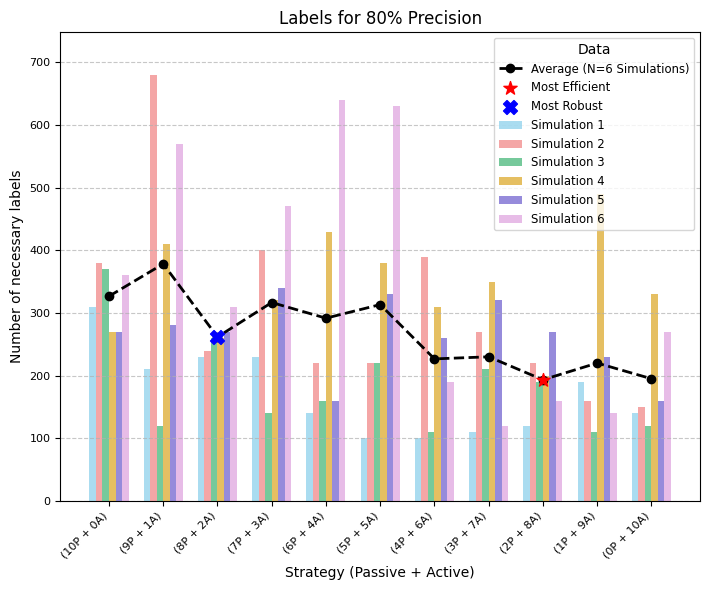

In [1]:
import matplotlib.pyplot as plt
import numpy as np

sim1_labels_80 = {
    '(10P + 0A)': 310, '(9P + 1A)': 210, '(8P + 2A)': 230, '(7P + 3A)': 230,
    '(6P + 4A)': 140, '(5P + 5A)': 100, '(4P + 6A)': 100, '(3P + 7A)': 110,
    '(2P + 8A)': 120, '(1P + 9A)': 190, '(0P + 10A)': 140
}
sim2_labels_80 = {
    '(10P + 0A)': 380, '(9P + 1A)': 680, '(8P + 2A)': 240, '(7P + 3A)': 400,
    '(6P + 4A)': 220, '(5P + 5A)': 220, '(4P + 6A)': 390, '(3P + 7A)': 270,
    '(2P + 8A)': 220, '(1P + 9A)': 160, '(0P + 10A)': 150
}
sim3_labels_80 = {
    '(10P + 0A)': 370, '(9P + 1A)': 120, '(8P + 2A)': 260, '(7P + 3A)': 140,
    '(6P + 4A)': 160, '(5P + 5A)': 220, '(4P + 6A)': 110, '(3P + 7A)': 210,
    '(2P + 8A)': 190, '(1P + 9A)': 110, '(0P + 10A)': 120
}
sim4_labels_80 = {
    '(10P + 0A)': 270, '(9P + 1A)': 410, '(8P + 2A)': 260, '(7P + 3A)': 320,
    '(6P + 4A)': 430, '(5P + 5A)': 380, '(4P + 6A)': 310, '(3P + 7A)': 350,
    '(2P + 8A)': 200, '(1P + 9A)': 490, '(0P + 10A)': 330
}
sim5_labels_80 = {
    '(10P + 0A)': 270, '(9P + 1A)': 280, '(8P + 2A)': 270, '(7P + 3A)': 340,
    '(6P + 4A)': 160, '(5P + 5A)': 330, '(4P + 6A)': 260, '(3P + 7A)': 320,
    '(2P + 8A)': 270, '(1P + 9A)': 230, '(0P + 10A)': 160
}
sim6_labels_80 = {
    '(10P + 0A)': 360, '(9P + 1A)': 570, '(8P + 2A)': 310, '(7P + 3A)': 470,
    '(6P + 4A)': 640, '(5P + 5A)': 630, '(4P + 6A)': 190, '(3P + 7A)': 120,
    '(2P + 8A)': 160, '(1P + 9A)': 140, '(0P + 10A)': 270
}

strategies = list(sim1_labels_80.keys())
n_strategies = len(strategies)

labels_all = np.array([
    [sim1_labels_80[s] for s in strategies],
    [sim2_labels_80[s] for s in strategies],
    [sim3_labels_80[s] for s in strategies],
    [sim4_labels_80[s] for s in strategies],
    [sim5_labels_80[s] for s in strategies],
    [sim6_labels_80[s] for s in strategies]
])

labels_mean = np.mean(labels_all, axis=0)
labels_std = np.std(labels_all, axis=0) 

best_strategy_index = np.argmin(labels_mean)
most_stable_index = np.argmin(labels_std)

plt.figure(figsize=(7.2, 6))
bar_width = 0.12 
index = np.arange(n_strategies)

plt.bar(index - 2.5 * bar_width, labels_all[0], bar_width, label='Simulation 1', color='skyblue', alpha=0.7)
plt.bar(index - 1.5 * bar_width, labels_all[1], bar_width, label='Simulation 2', color='lightcoral', alpha=0.7)
plt.bar(index - 0.5 * bar_width, labels_all[2], bar_width, label='Simulation 3', color='mediumseagreen', alpha=0.7)
plt.bar(index + 0.5 * bar_width, labels_all[3], bar_width, label='Simulation 4', color='goldenrod', alpha=0.7)
plt.bar(index + 1.5 * bar_width, labels_all[4], bar_width, label='Simulation 5', color='slateblue', alpha=0.7)
plt.bar(index + 2.5 * bar_width, labels_all[5], bar_width, label='Simulation 6', color='plum', alpha=0.7)

plt.plot(
    index, 
    labels_mean, 
    marker='o', 
    linestyle='--', 
    color='black', 
    label='Average (N=6 Simulations)',
    linewidth=2, 
    zorder=10
)

plt.scatter(index[best_strategy_index], labels_mean[best_strategy_index], 
            color='red', s=100, label=f'Most Efficient', zorder=11, marker='*')
plt.scatter(index[most_stable_index], labels_mean[most_stable_index], 
            color='blue', s=100, label=f'Most Robust', zorder=11, marker='X')

plt.title('Labels for 80% Precision', fontsize=12)
plt.xlabel('Strategy (Passive + Active)', fontsize=10)
plt.ylabel('Number of necessary labels', fontsize=10)
plt.xticks(index, strategies, rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.legend(loc='upper right', title='Data', fontsize='small')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, np.max(labels_all) * 1.1) 
plt.tight_layout()
plt.show()

## Robustness Analysis

This cell stores the raw labels-to-$80\%$ data from $N=6$ simulations. Its objective is to calculate and plot the Standard Deviation ($\sigma$) of these results for each P:A strategy. The generated Robustness Profile Plot visually represents the training variability, highlighting the most stable (lowest $\sigma$) and most unstable (highest $\sigma$) strategies.

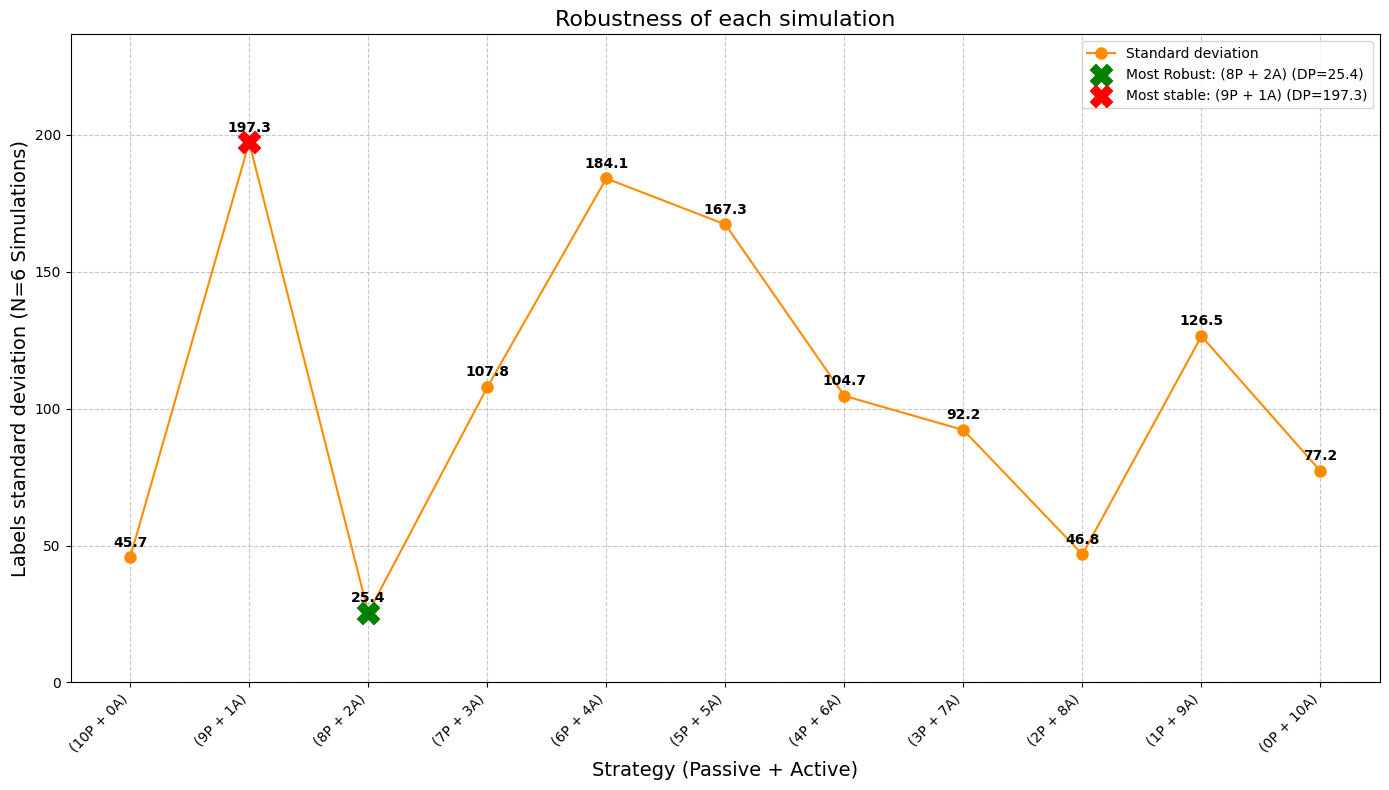

In [2]:
import matplotlib.pyplot as plt
import numpy as np

sim1_labels_80 = [310, 210, 230, 230, 140, 100, 100, 110, 120, 190, 140]
sim2_labels_80 = [380, 680, 240, 400, 220, 220, 390, 270, 220, 160, 150]
sim3_labels_80 = [370, 120, 260, 140, 160, 220, 110, 210, 190, 110, 120]
sim4_labels_80 = [270, 410, 260, 320, 430, 380, 310, 350, 200, 490, 330]
sim5_labels_80 = [270, 280, 270, 340, 160, 330, 260, 320, 270, 230, 160]
sim6_labels_80 = [360, 570, 310, 470, 640, 630, 190, 120, 160, 140, 270]

strategies = [
    '(10P + 0A)', '(9P + 1A)', '(8P + 2A)', '(7P + 3A)', 
    '(6P + 4A)', '(5P + 5A)', '(4P + 6A)', '(3P + 7A)', 
    '(2P + 8A)', '(1P + 9A)', '(0P + 10A)'
]
n_strategies = len(strategies)

labels_all = np.array([
    sim1_labels_80, sim2_labels_80, sim3_labels_80, 
    sim4_labels_80, sim5_labels_80, sim6_labels_80
])

labels_std = np.std(labels_all, axis=0)

most_stable_index = np.argmin(labels_std)
most_unstable_index = np.argmax(labels_std)

plt.figure(figsize=(14, 8))

plt.plot(strategies, labels_std, marker='o', linestyle='-', markersize=8, color='darkorange', label='Standard deviation')

plt.scatter(strategies[most_stable_index], labels_std[most_stable_index], 
            color='green', s=250, zorder=5, marker='X',
            label=f'Most Robust: {strategies[most_stable_index]} (DP={labels_std[most_stable_index]:.1f})')

plt.scatter(strategies[most_unstable_index], labels_std[most_unstable_index], 
            color='red', s=250, zorder=5, marker='X',
            label=f'Most stable: {strategies[most_unstable_index]} (DP={labels_std[most_unstable_index]:.1f})')

y_offset = max(labels_std) * 0.02 
for i, val in enumerate(labels_std):
    plt.text(i, val + y_offset, f"{val:.1f}", ha='center', fontsize=10, weight='bold')

plt.title('Robustness of each simulation', fontsize=16)
plt.xlabel('Strategy (Passive + Active)', fontsize=14)
plt.ylabel('Labels standard deviation (N=6 Simulations)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.ylim(0, max(labels_std) * 1.2)
plt.tight_layout()
plt.show()